In [1]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

# TASK:

For certified cases (`case_status` = “Certified”), build a model that predicts `wage_offered` by using **5** features with the most predictive power.

## Dataset
- `case_number`: (Index) identification of each case. 
- `case_received_date`: (Date) when the case was received
- `decision_date`: (Date) when a decision on the case was made
- `case_status`: (Cat) the decision on the case
- `employer_name`: (Cat) the employer applying for the case
- `employer_num_employees`: (Num) the number of employees employed by the employer
- `employer_yr_established`: (Num) the year the employer was established
- `job_education`: (Cat) the education level required for the job offered
- `job_experience_num_month`: (Num) the experience required for the job offered, in months
- `job_state`: (Cat) the location of the job
- `job_foreign_lang_req`: (Cat) if a foreign language was required for the job
- `job_level`: (Num) the level of the job offered
- `employee_citizenship`: (Cat) the citizenship of the employee
- `wage_offer`: (Num) the wage offered, or the lower-end of the wage offered
- `wage_unit`: (Cat) the unit of the wage

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
warnings.filterwarnings("ignore")

raw_data = pd.read_csv('data_perm_take_home.csv', encoding = "ISO-8859-1", engine='python')
data = raw_data[raw_data['case_status'] == 'Certified']

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37930 entries, 0 to 61612
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   case_number                37930 non-null  object 
 1   case_received_date         37930 non-null  object 
 2   decision_date              37930 non-null  object 
 3   case_status                37930 non-null  object 
 4   employer_name              37930 non-null  object 
 5   employer_num_employees     37930 non-null  float64
 6   employer_yr_established    37929 non-null  float64
 7   job_education              37930 non-null  object 
 8   job_experience_num_months  20997 non-null  float64
 9   job_state                  37930 non-null  object 
 10  job_foreign_lang_req       37930 non-null  object 
 11  job_level                  35277 non-null  float64
 12  employee_citizenship       37930 non-null  object 
 13  wage_offer                 37930 non-null  flo

# Workflow

## 1. Data Cleaning

## 2. Feature Engineering

## 3. Modeling

## 4. Evaluation

# 1. Data Cleaning

- Imputation
- Special Transformation
- Outlier Detection

### Imputation

- For target(response variable), the missing values are simply dropped since the number is not large.
- For features(predictors), `job_experience_num_months` has too many missing so just drop this column for convenience. Other columns use corresponding median to impute. Also there're other alternative ways, like mean, random sampling.

In [3]:
# Count missing values number 
data.wage_unit.isna().sum()

365

In [4]:
# Drop nan value
data.dropna(subset=['wage_offer', 'wage_unit'], inplace=True)
data.set_index('case_number',inplace=True)

# Impute with median
def impute_by_mean(df):
    df.fillna(df.median(), inplace=True)
impute_by_mean(data)

### Special Transformation

- Unlike regular dataset, the target `wage_offer` here is scaled in different units `wage_unit`. 
- In order to unify, assume `Year = 12 Months = 50 Weeks = 2000 Hours`. Thus the target is in the same unit: Year.

In [5]:
# Check wage_unit
data.wage_unit.value_counts()

Year     37117
Hour       442
Week         4
Month        2
Name: wage_unit, dtype: int64

In [6]:
# Uniform all wage_unit to Year
# Assuming Year = 12 Months = 50 Weeks = 2000 Hours
unit_dict = {'Year': 1, 'Month': 12, 'Week': 50, 'Hour': 2000}
unit_number = data['wage_unit'].apply(lambda x: unit_dict[x])
data['wage_offer'] = data['wage_offer'] * unit_number
data.drop(columns=['wage_unit'], inplace=True)

### Outlier Detection

    - In my work, for simplification and time limitation, I didn't do Outlier Detection work for the data set.
    - There're multiple ways to detect outliers and imputation, like Z-score, Percentile.

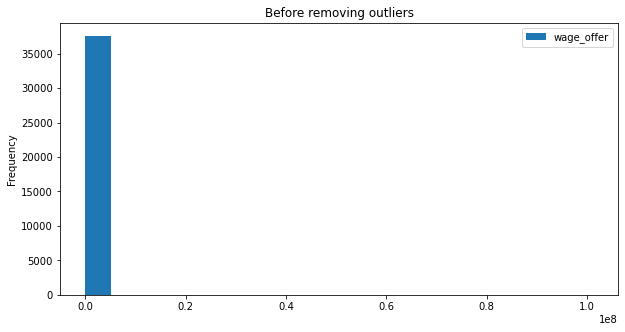

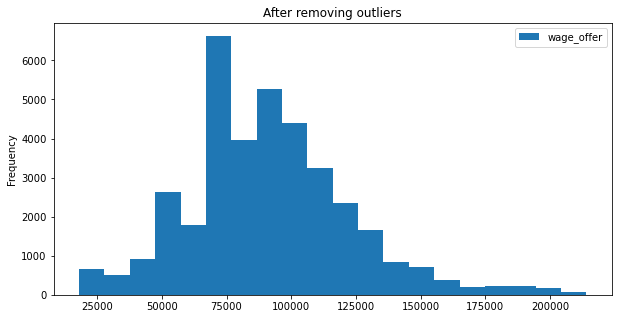

In [7]:
hist1 = data[['wage_offer']].plot(kind='hist', bins=20, figsize=(10, 5), title='Before removing outliers')

# Detect outliers
q_low = data["wage_offer"].quantile(0.01)
q_hi  = data["wage_offer"].quantile(0.99)
data = data[(data["wage_offer"] < q_hi) & (data["wage_offer"] > q_low)]

hist2 = data[['wage_offer']].plot(kind='hist', bins=20, figsize=(10, 5), title='After removing outliers')

# 2. Feature Engineering

- `case_received_date`, `decision_date` -> **Case Duration**
- `job_education`, `job_foreign_lang_req` (Several Classes) -> **Label Encoding**
- `employer_name`, `job_state`, `employee_citizenship` (Mass Classes) -> **Target Encoding**

In [8]:
# Case Duration Feature
def get_duration(df):
    duration = pd.to_datetime(df['decision_date']) - pd.to_datetime(df['case_received_date'])
    return duration.apply(lambda x: x.days)

# Target Mean Encoding
def mean_wage_encoding(df, column):
    
    encoding_dict = df.groupby(column)['wage_offer'].mean()
    default_mean = df['wage_offer'].mean()
    
    return df[column].apply(lambda x: encoding_dict.get(x, default_mean))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def feature_tranform(df):
    df['duration'] = get_duration(df)
    df['employer_mean_wage'] = mean_wage_encoding(df, 'employer_name')
    df['state_mean_wage'] = mean_wage_encoding(df, 'job_state')
    df['citizen_mean_wage'] = mean_wage_encoding(df, 'employee_citizenship')
    
    df['job_education'] = le.fit_transform(df['job_education'])
    df['job_foreign_lang_req'] = le.fit_transform(df['job_foreign_lang_req'])
    return df

In [9]:
# Check job_education
data.job_education.value_counts()

Master's       17051
Bachelor's     15526
None            1520
Doctorate       1448
Other            771
High School      256
Associate's      203
Name: job_education, dtype: int64

In [10]:
# Check employer_name
data.employer_name.value_counts()

COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION    5356
INTEL CORPORATION                                1313
GOOGLE INC.                                       618
CISCO SYSTEMS, INC.                               610
QUALCOMM TECHNOLOGIES INC.                        582
                                                 ... 
ORION BUSINESS SOLUTIONS, LLC                       1
DICE CAREER SOLUTIONS                               1
INFOTECH PRISM LLC                                  1
RAJU & GADIRAJU INC                                 1
HOBART AND WILLIAM SMITH COLLEGES                   1
Name: employer_name, Length: 11194, dtype: int64

### Conditional Distribution by Employer

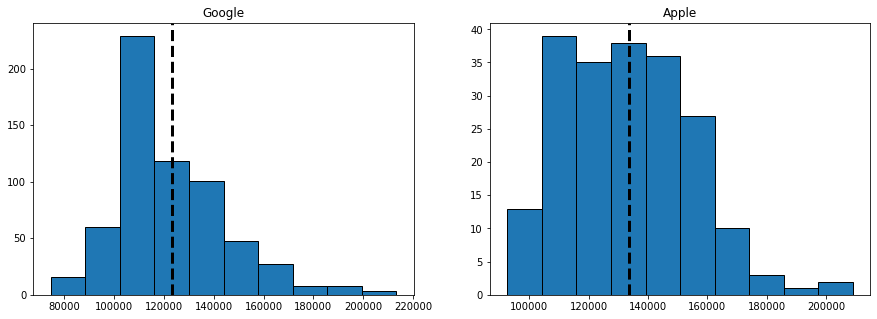

In [11]:
google = data[data.employer_name == 'GOOGLE INC.']
apple = data[data.employer_name == 'APPLE INC.']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(google.wage_offer, edgecolor='k')
ax1.axvline(google.wage_offer.mean(), color='k', linestyle='dashed', linewidth=3)
ax1.title.set_text('Google')

ax2.hist(apple.wage_offer, edgecolor='k')
ax2.axvline(apple.wage_offer.mean(), color='k', linestyle='dashed', linewidth=3)
ax2.title.set_text('Apple')

### Heat Map 

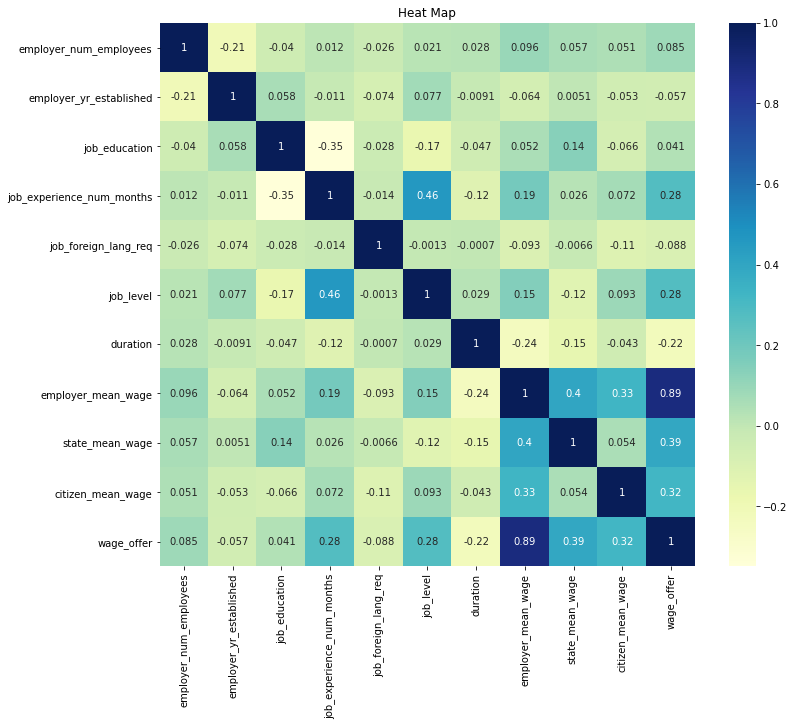

In [12]:
import seaborn as sns

DATA = feature_tranform(data)
_, ax = plt.subplots(figsize=(12, 10))
ax.set(title="Heat Map")
feature_name = ['employer_num_employees', 'employer_yr_established', 'job_education', 'job_experience_num_months', 
         'job_foreign_lang_req', 'job_level', 'duration', 'employer_mean_wage', 'state_mean_wage', 'citizen_mean_wage']
ax = sns.heatmap(DATA[feature_name + ['wage_offer']].corr(), cmap='YlGnBu', ax=ax, annot=True)

### Note: 

After feature enginneering and before modeling, there is a very important part: `Standardization` or `Scaling`.

# 3. Modeling

- Random Forest
    - Pros
        - Not likely to overfit.
        - Robust to categorical features.
        - Robust to unscaled features.
        - Robust to outliers.
        - Nonlinearity.
        - Easy to implement.
        - Feature Importance.
    - Cons
        - Complexity

- Other methods
    - Linear Model
    - Regerssion Tree
    - Gradient Boosting
    - Neural Network
    - Parametric Distributions Fitting

## Feature Importance

Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

In scikit-learn the `RandomForestRegressor` model provides a `feature_importances_` property that can be accessed to retrieve the relative importance scores for each input feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature.

In [13]:
feature_importance = {
    'employer_num_employees': 0.02983592484680458,
     'employer_yr_established': 0.019606441875842644,
     'job_education': 0.009773653500957045,
     'job_experience_num_months': 0.010743082822701719,
     'job_foreign_lang_req': 0.0006214114232062333,
     'job_level': 0.026386892610025133,
     'duration': 0.032031890664900815,
     'employer_mean_wage': 0.8317521990929074,
     'state_mean_wage': 0.017870984735958686,
     'citizen_mean_wage': 0.02137751842669555
}

pd.Series(feature_importance).sort_values(ascending=False)

employer_mean_wage           0.831752
duration                     0.032032
employer_num_employees       0.029836
job_level                    0.026387
citizen_mean_wage            0.021378
employer_yr_established      0.019606
state_mean_wage              0.017871
job_experience_num_months    0.010743
job_education                0.009774
job_foreign_lang_req         0.000621
dtype: float64

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Train with best 5 features

best_feature = ['employer_mean_wage',  'duration', 'employer_num_employees', 'job_level', 'citizen_mean_wage']

X = DATA[best_feature]
y = DATA['wage_offer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
reg = RandomForestRegressor(random_state=0)
trained = reg.fit(X_train, y_train)

# 4. Evaluation

In [15]:
y_pred = reg.predict(X_test)
residual = (y_pred - y_test)

res_ci_lo = residual.mean() - 3  * residual.std()
res_ci_hi = residual.mean() + 3  * residual.std()

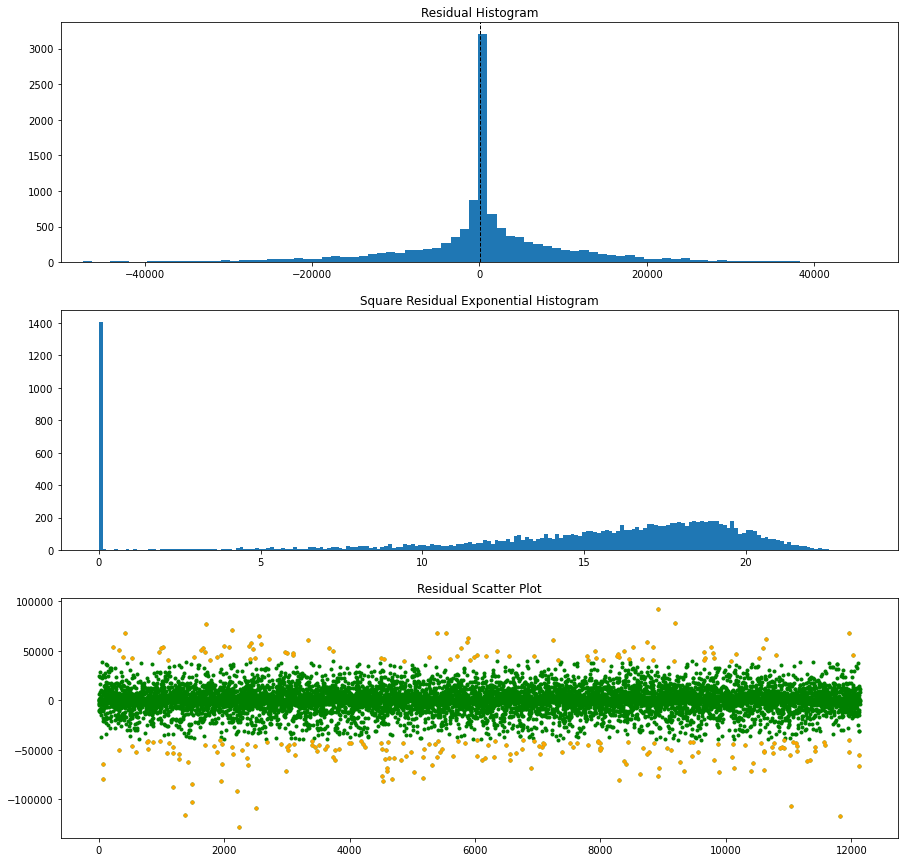

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

ax1.hist(residual, bins=200)
ax1.axvline(residual.mean(), color='k', linestyle='dashed', linewidth=1)
ax1.set(title='Residual Histogram', xlim=(-50000, 50000))

ax2.hist(np.log(residual**2 + 1), bins=200)
ax2.set(title='Square Residual Exponential Histogram')

upper_index = np.where(residual > res_ci_hi)[0]
lower_index = np.where(res_ci_lo > residual)[0]
ax3.scatter(np.arange(len(residual)), residual, marker='.', color='g')
ax3.scatter(upper_index, residual[upper_index], marker='.', color='orange')
ax3.scatter(lower_index, residual[lower_index], marker='.', color='orange')
txt = ax3.set(title='Residual Scatter Plot')

# Future work

- **Data Preprocessing**
    - Outlier Detection
    - Imputation
- **Feature Engineering**
    - Encoding
    - Time Series
    - Other
- **Algorithm**
    - Hyper-paramter Tuning
    - Other algorithm
- **Pipeline**
    - Data Leakage
    - Standarization & Scaling